![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Recuperados inicialmente.

In [8]:
initially_recovered = 0

Onde está a pasta base que contém os dados?

In [9]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos? A coluna escolhida deve conter o **total de casos** até a data da linha em que se encontra.

In [10]:
data_column_to_fit ='total_cases_ESTIMATED' #'total_cases' #'total_cases_ESTIMATED_FROM_SRAG' #'total_cases' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Caso tenhamos dfados de sobreviventes, além de óbitos, podemos fazer o ajuste do modelo de modo a empregar essa informação.

In [11]:
use_survival_data_to_fit = False

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [12]:
target_location = 'Brazil'
#target_location = 'SP'
#target_location = 'São Paulo-SP-Brazil'

Opcionalmente, podemos incorporar dados específicos do Brasil a partir de arquivos separados.

In [13]:
use_separate_brazil_data = True

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [14]:
infer_parameters_from_data = True

Ao inferir os parâmetros a partir dos dados, devemos definir o momento inicial da epidemia. Aqui há dois modos para se especificar isso:

  - Implicitamente, definindo qual o número mínimo de casos que desejamos.
  - Explicitamente, fornecendo a data.

**Deve-se usar apenas um desses dois modos, deixando a outra variável como `None`**

In [15]:
min_initial_cases = 50
min_initial_date = None #pd.Timestamp(2020, 3, 12)

Onde queremos armazenar resultados do modelo para posterior.

In [16]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [17]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [18]:
run_sensitivity_analysis = True

Qual o intervalo de dias entre uma estimativa e a seguinte ao se selecionar a quantidade de dados históricos para cada execução da análise de sensibilidade?

In [19]:
sensitivity_analysis_step = 1

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [20]:
# custom papermill parameters

## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [21]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [22]:
def plot_simple_simulation_output(df_simulated_data, title, min_peak_proportion_to_show=0.01, start_date=None, end_date=None, file_path_base=results_folder, file_name=None):
    
    def aux_file_path():
        return file_path_base + 'seir_' + file_name + f'.{target_location.lower()}' + results_suffix + '.png'
    
    peak_date = df_simulated_data["E+I"].idxmax().date()
    
    df_simulated_data = df_simulated_data.loc[start_date:end_date]
    df_simulated_data = df_simulated_data[['E+I']]
    peak_value = df_simulated_data.loc[peak_date, 'E+I']
    df_simulated_data = df_simulated_data[df_simulated_data['E+I'] >= peak_value * min_peak_proportion_to_show]
    
    ax = sns.lineplot(data=df_simulated_data)
    ax.set_title(title)
    if file_name is not None:
        ax.figure.savefig(aux_file_path(), format='png')
    plt.figure()
    

In [23]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [:comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    for i in range(0, len(best)):
        key = f'duration_{i}'
        cur_intervention_date = epidemic_start_date
        if key in best:
            cur_intervention_date = cur_intervention_date + pd.DateOffset(days=int(best[key]))
            plt.axvline(cur_intervention_date, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

In [24]:
def enforce_bounds(value, lower_bound=0.0, upper_bound=1.0):
    return max(min(value, upper_bound), lower_bound)

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [25]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

#df_epidemy_data = pd.read_csv(f'{data_folder}preprocessed/full_data_Brasil_06_05_2020.csv', parse_dates=['date'])
#df_locations_data = pd.read_csv(f'{data_folder}preprocessed/locations_Brasil.csv')


# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,population
0,2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0
1,2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [26]:
if use_separate_brazil_data:
    df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
    #print(df_brazil_city_data.tail())

    def aux_build_location(row):
        if not pd.isnull(row['city']):
            prefix = f"{row['city']}-"
        else:
            prefix = ""

        return prefix + f"{row['state']}-Brazil"

    df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

    df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
    df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
    df_brazil_city_data.tail()

In [27]:
if use_separate_brazil_data:
    df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
    df_epidemy_data.tail()

Selecionemos apenas dados sobre o país de interesse.

In [28]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [29]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-09-15,3.123471
2020-09-16,3.123471
2020-09-17,3.123471
2020-09-18,3.123471
2020-09-19,3.123471


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,,,,,
2020-09-21,16389.0,363.0,4544629.0,136895.0,214174.0,5270.0,407108.0,10245.0,212559409.0,NaN,6.679370e+07,2.564559e+07
2020-09-22,13439.0,377.0,4558068.0,137272.0,212458.0,5266.0,410274.0,10312.0,212559409.0,NaN,6.724897e+07,2.574039e+07
2020-09-23,33536.0,836.0,4591604.0,138108.0,209341.0,4989.0,429531.0,10644.0,212559409.0,NaN,6.769756e+07,2.583380e+07
2020-09-24,33281.0,869.0,4624885.0,138977.0,205802.0,4871.0,426996.0,10438.0,212559409.0,NaN,6.813856e+07,2.592563e+07
2020-09-25,32817.0,831.0,4657702.0,139808.0,202316.0,4873.0,419256.0,10286.0,212559409.0,NaN,6.857210e+07,2.601590e+07


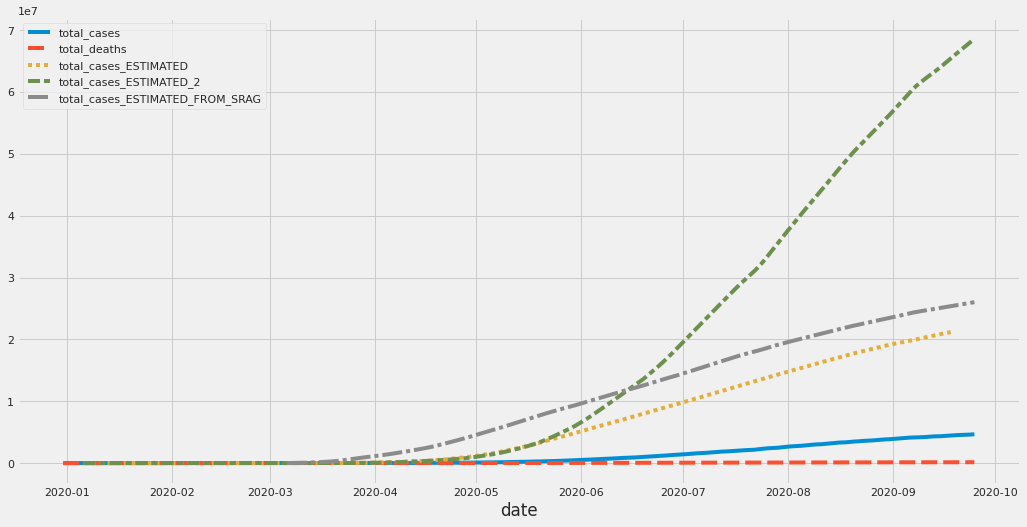

In [30]:
# https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
#
# fatality rate = 0.0065 #0.004 
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.0065).shift(-7).rolling(7).mean()

df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases'].rolling(7).mean()

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum().rolling(7).mean()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 'total_cases_ESTIMATED_FROM_SRAG']])
df_data_target.tail()

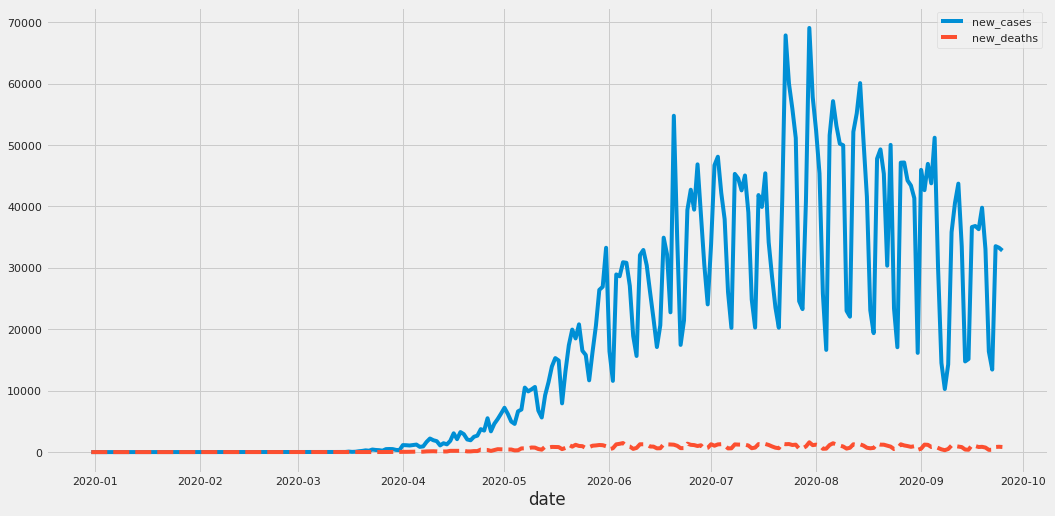

In [31]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

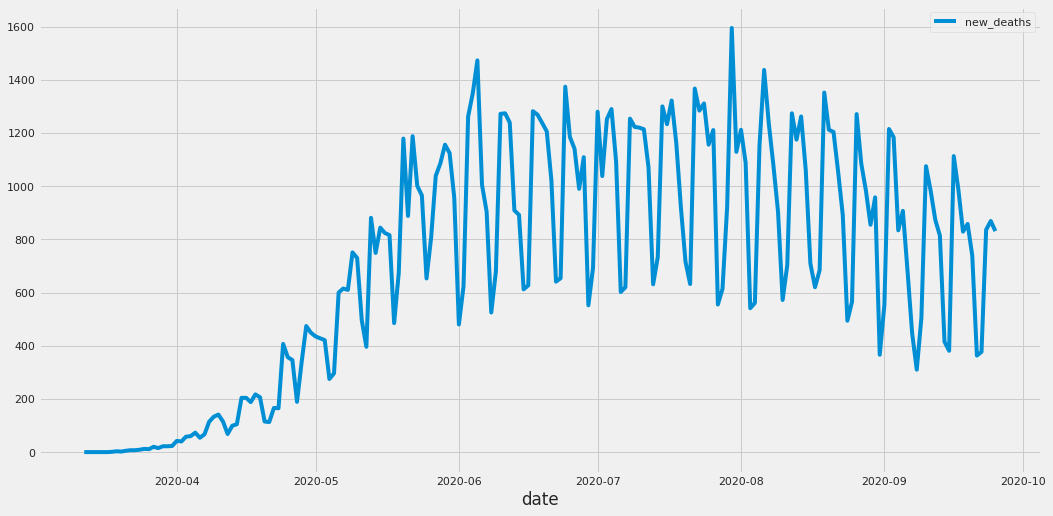

In [81]:
sns.lineplot(data=df_data_target[['new_deaths']])

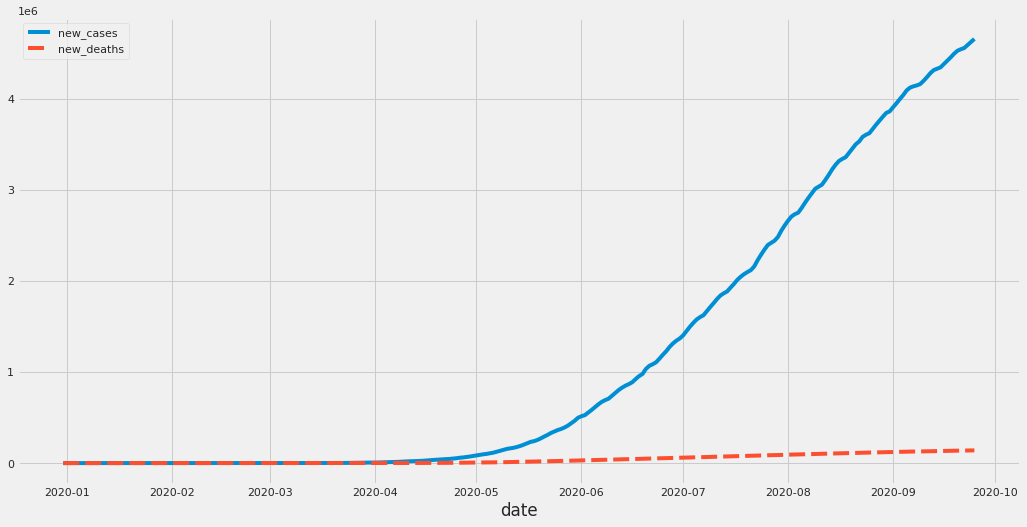

In [32]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']].cumsum())

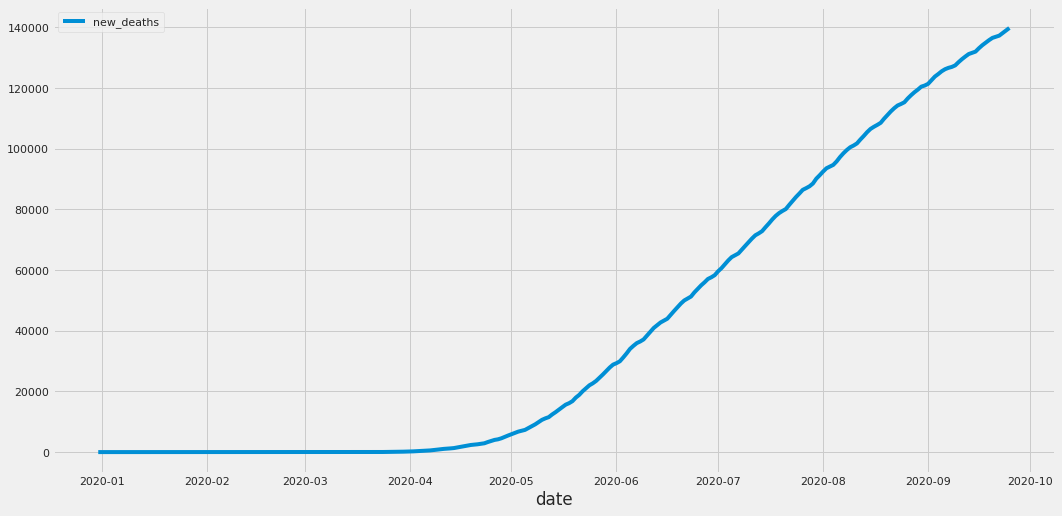

In [33]:
sns.lineplot(data=df_data_target[['new_deaths']].cumsum())

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [34]:
if min_initial_cases is not None:
    print(df_data_target[df_data_target[data_column_to_fit] >= min_initial_cases][data_column_to_fit].index[0])
else:
    print(min_initial_date)

2020-03-12 00:00:00


In [35]:
if infer_parameters_from_data:
    if min_initial_cases is not None:
        epidemic_start_date = df_data_target[df_data_target[data_column_to_fit] >= min_initial_cases][data_column_to_fit].index[0]
    else:
        epidemic_start_date = min_initial_date
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    if use_survival_data_to_fit:
        initially_recovered = first_date_row['total_survivors'] + first_date_row['total_deaths']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-12 00:00:00, population_size=212559409.0, initially_infected=109.89010989010988


Filtremos os dados a partir da data de interesse.

In [36]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [37]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [38]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [39]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [40]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [41]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [42]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [43]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [44]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [45]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [46]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [47]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [48]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125593e+08,109.890110,0.000000,0.000000,0.000000,0.000000,0.000000,109.890110,109.890110
2020-03-13,2.125593e+08,10.989011,0.000000,98.901099,98.901099,0.000000,0.000000,109.890110,109.890110
2020-03-14,2.125592e+08,80.219739,79.120838,79.120879,9.890110,29.670330,29.670330,159.340618,189.010948
2020-03-15,2.125592e+08,71.318621,63.296647,127.582381,72.197765,53.406593,23.736264,198.901002,252.307595
2020-03-16,2.125591e+08,109.197646,102.065783,153.494425,64.186759,91.681308,38.274714,262.692071,354.373379


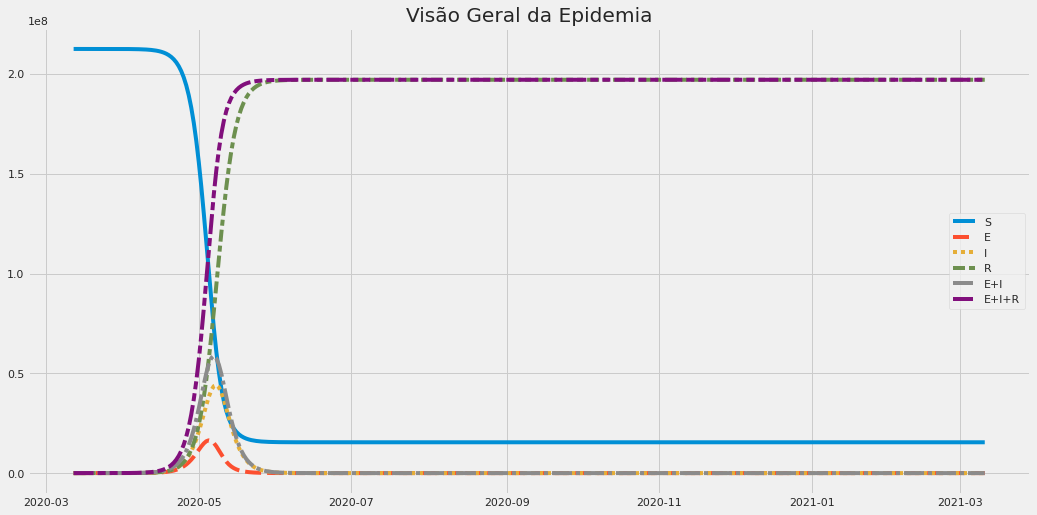

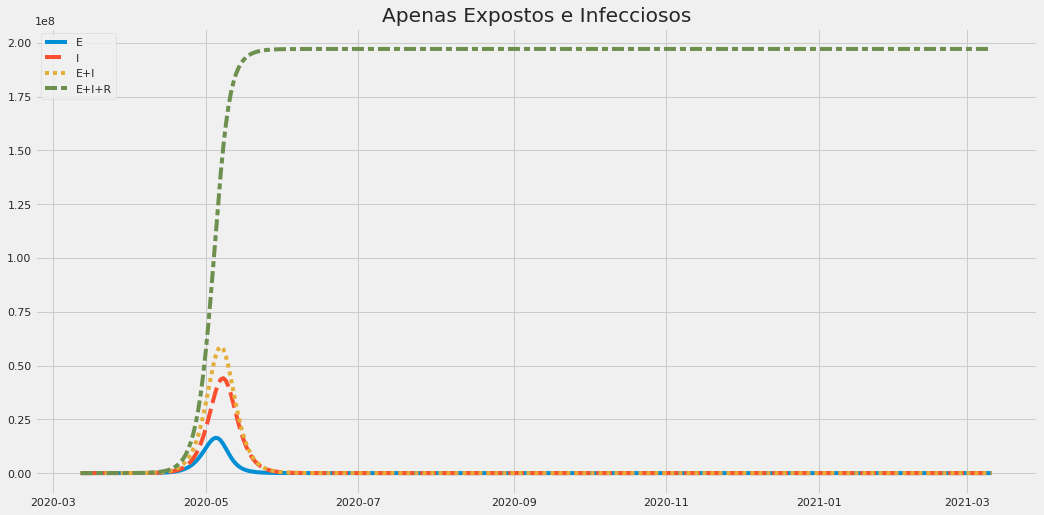

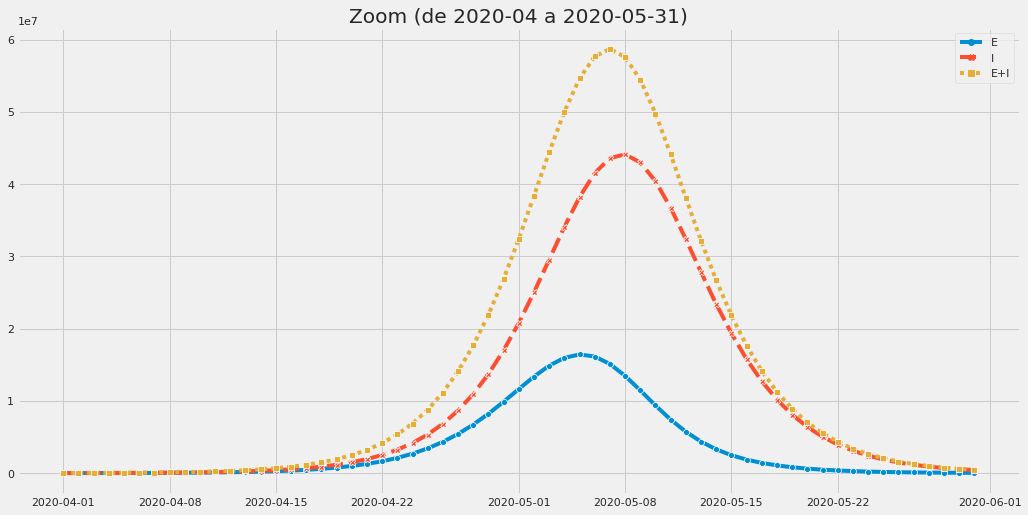

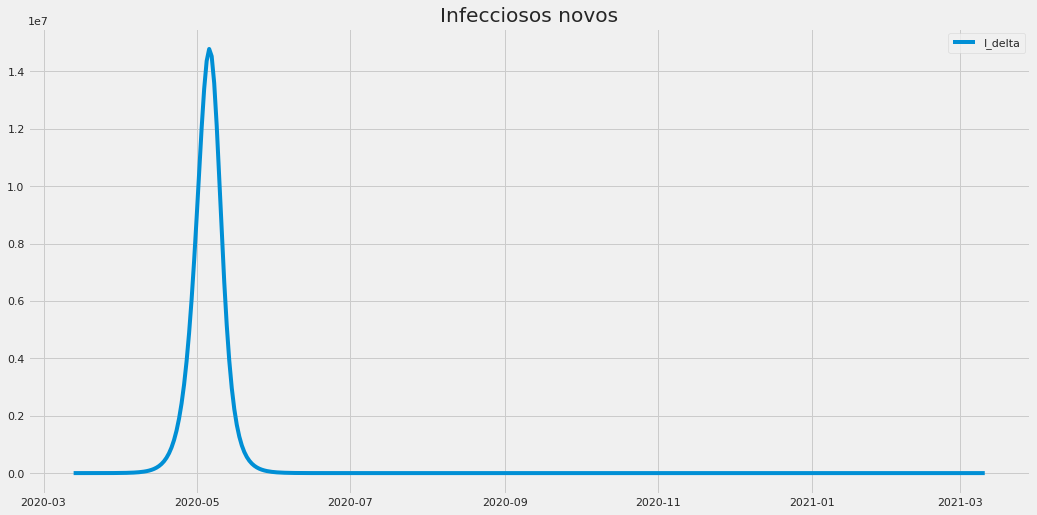

<Figure size 1152x576 with 0 Axes>

In [49]:
df_simulation_data = simulate(S=population_size - initially_infected - initially_recovered, 
                              E =initially_infected, 
                              I=0, 
                              R=initially_recovered, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

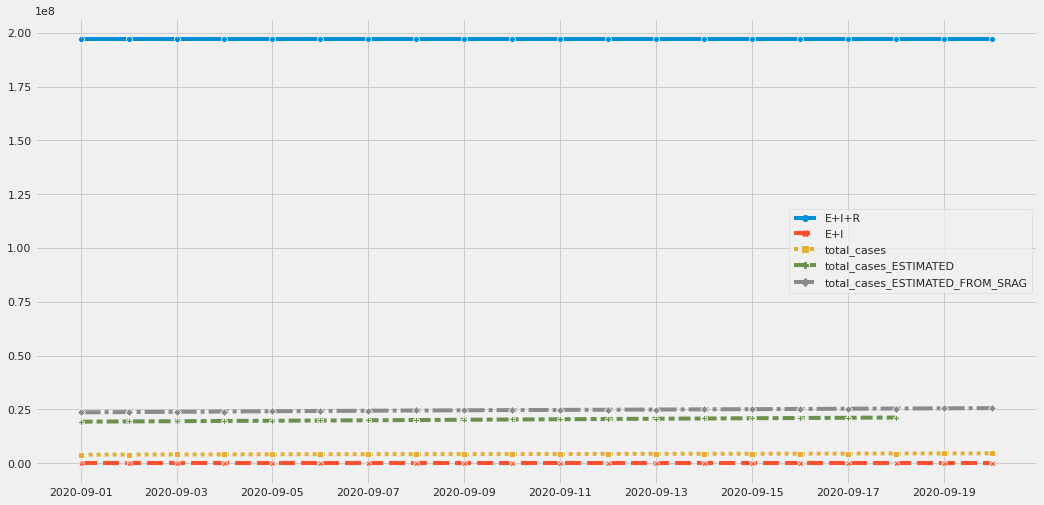

In [50]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [51]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125593e+08,109.890110,0.000000,0.000000,0.000000,0.000000,0.000000,109.890110,109.890110
2020-03-13,2.125593e+08,0.000000,0.000000,109.890110,109.890110,0.000000,0.000000,109.890110,109.890110
2020-03-14,2.125592e+08,98.901048,98.901048,65.934066,0.000000,43.956044,43.956044,164.835114,208.791158
2020-03-15,2.125591e+08,59.340601,59.340601,138.461487,98.901048,70.329670,26.373626,197.802088,268.131759
2020-03-16,2.125590e+08,124.615181,124.615181,142.417493,59.340601,125.714265,55.384595,267.032675,392.746940


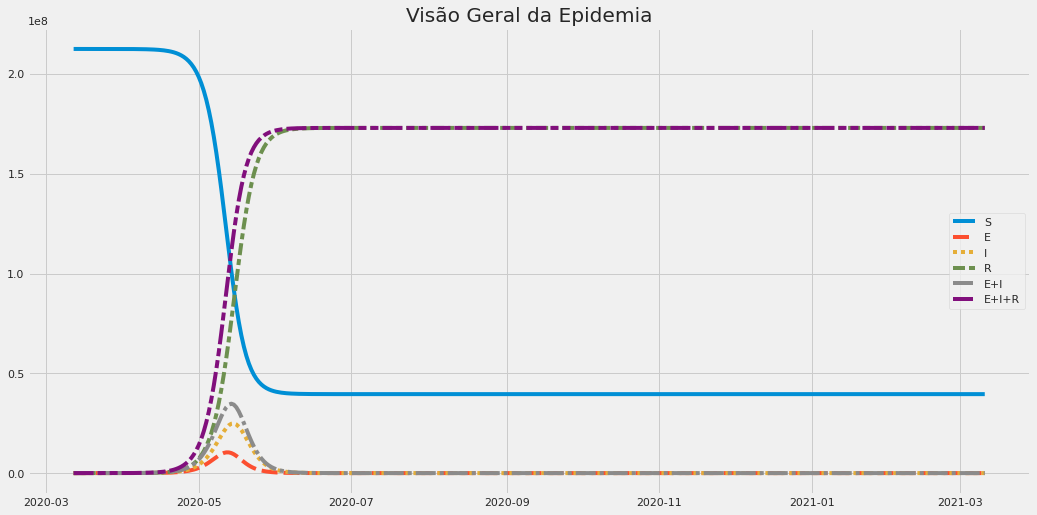

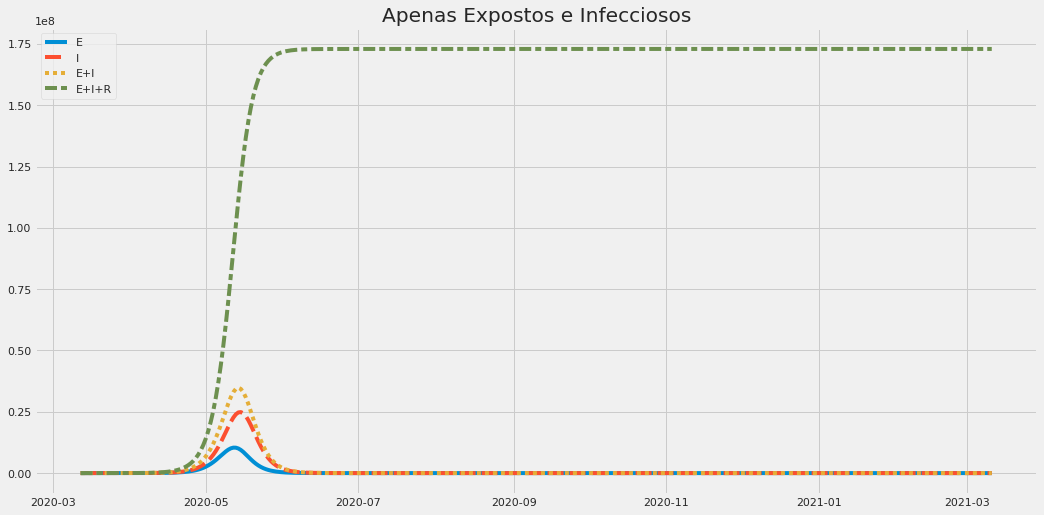

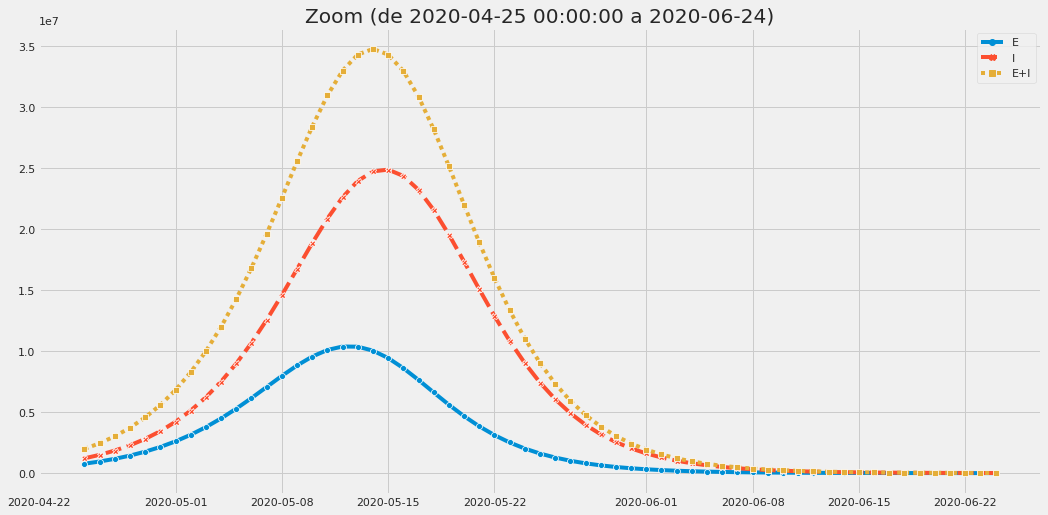

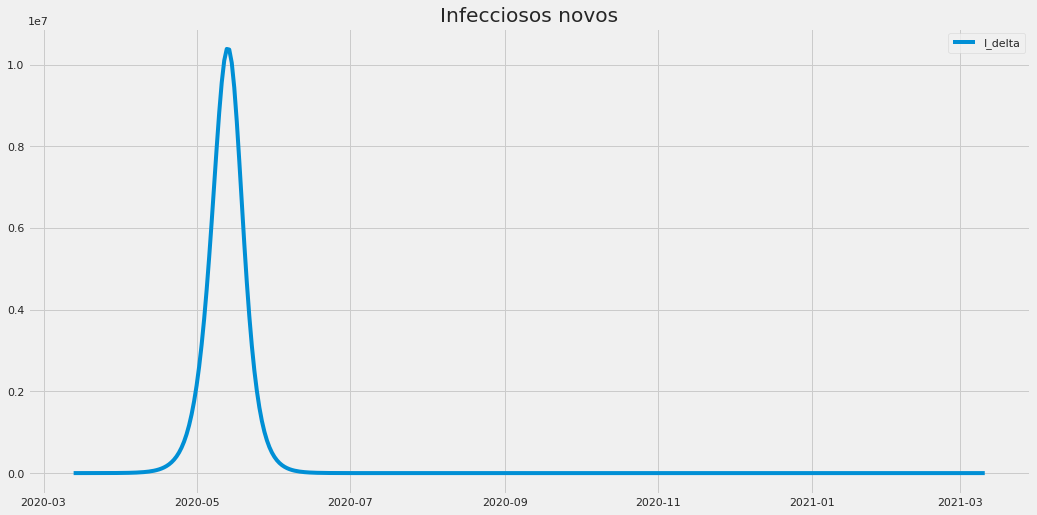

<Figure size 1152x576 with 0 Axes>

In [52]:
df_simulation_data = simulate(S=population_size - initially_infected - initially_recovered, 
                              E =initially_infected, 
                              I=0, 
                              R=initially_recovered, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

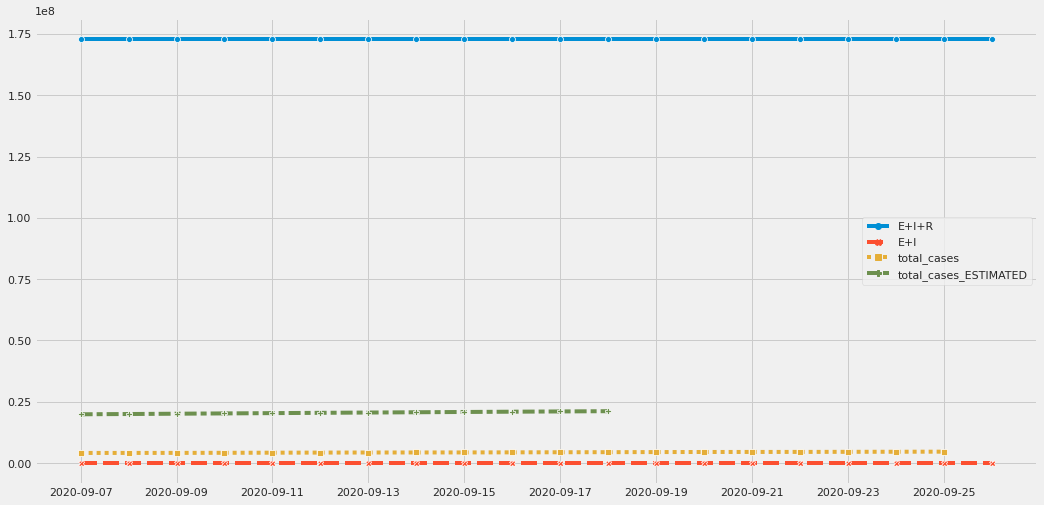

In [53]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [54]:
def objective_for_simulation(args):
    
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
        alpha = enforce_bounds(alpha)
        beta = enforce_bounds(beta)
        gamma = enforce_bounds(gamma)
        
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = enforce_bounds(params.get('alpha', prev_alpha))
            cur_beta = enforce_bounds(params.get('beta', prev_beta))
            cur_gamma = enforce_bounds(params.get('gamma', prev_gamma))
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected - initially_recovered, 
                              E=initially_infected,
                              I=0,
                              R=initially_recovered, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    if use_survival_data_to_fit:
        df_diff_cases = df_data_target[data_column_to_fit] - df_data_target['total_deaths'] - df_data_target['total_survivors'] -\
                                   (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'])
    else:
        df_diff_cases = df_data_target[data_column_to_fit] - \
                                   (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [55]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

100%|██████████| 1000/1000 [00:17<00:00, 56.52trial/s, best loss: 2084.64231719414] 
Best parameters found: {'alpha': 0.992601981286719, 'beta': 0.9965812990094094, 'gamma': 0.17758210373200406}


In [56]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-16,2.125589e+08,182.395879,181.722596,240.300188,90.335371,67.825235,32.381430,422.696067,490.521303
2020-03-17,2.125587e+08,240.827489,239.478121,378.673686,181.046511,110.498248,42.673013,619.501175,729.999423
2020-03-18,2.125583e+08,379.159464,377.377818,550.473859,239.045842,177.743918,67.245670,929.633323,1107.377241
2020-03-19,2.125578e+08,551.394124,548.589095,829.073988,376.354435,275.498224,97.754306,1380.468112,1655.966336
2020-03-20,2.125569e+08,830.312419,826.233195,1229.160185,547.314900,422.726927,147.228703,2059.472604,2482.199531


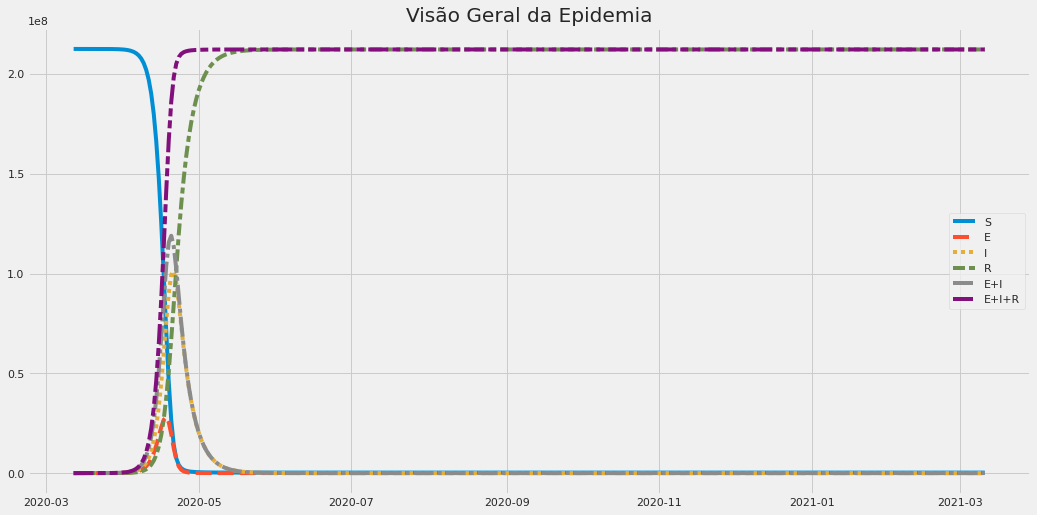

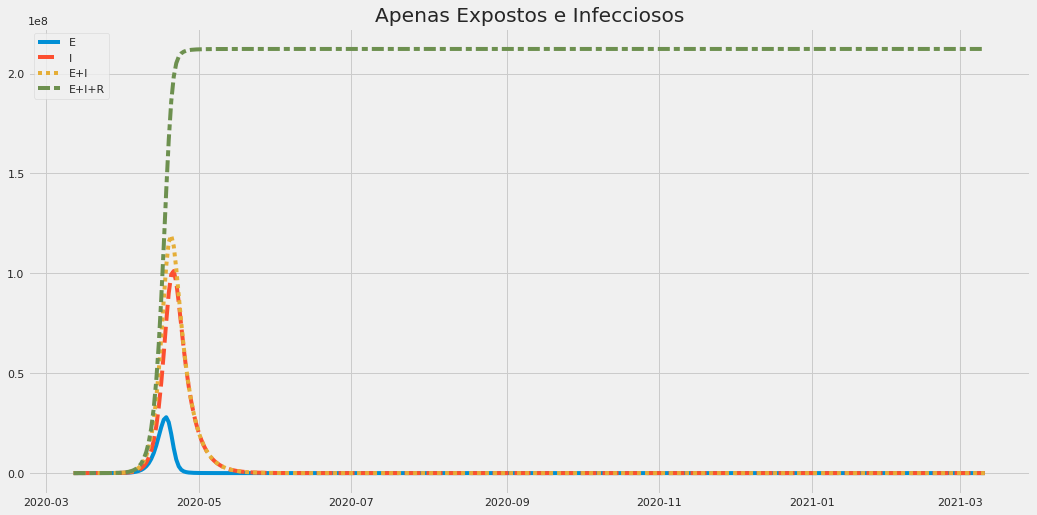

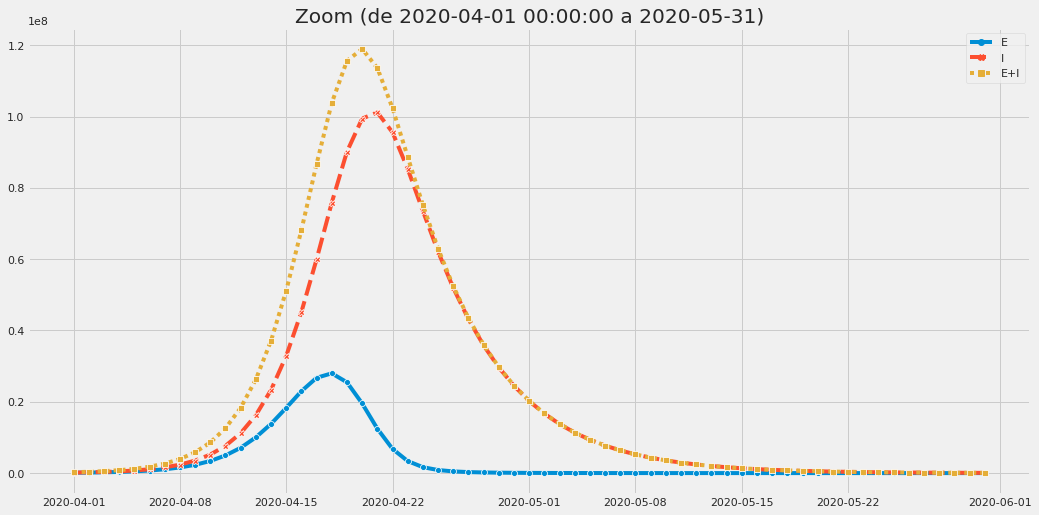

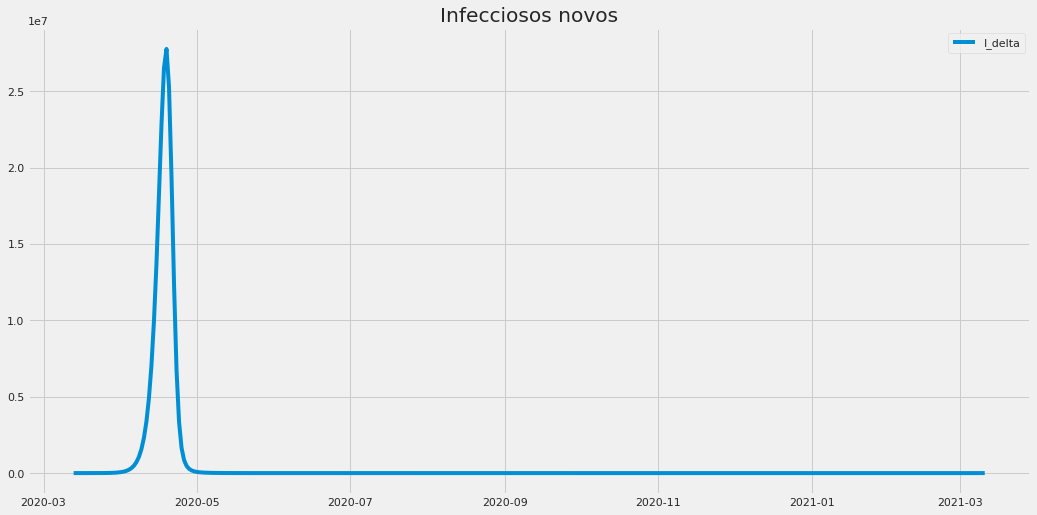

<Figure size 1152x576 with 0 Axes>

In [57]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected - initially_recovered, 
                              E=initially_infected,
                              I=0,
                              R=initially_recovered, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [58]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,,,,,
2020-09-21,16389.0,363.0,4544629.0,136895.0,214174.0,5270.0,407108.0,10245.0,212559409.0,NaN,6.679370e+07,2.564559e+07
2020-09-22,13439.0,377.0,4558068.0,137272.0,212458.0,5266.0,410274.0,10312.0,212559409.0,NaN,6.724897e+07,2.574039e+07
2020-09-23,33536.0,836.0,4591604.0,138108.0,209341.0,4989.0,429531.0,10644.0,212559409.0,NaN,6.769756e+07,2.583380e+07
2020-09-24,33281.0,869.0,4624885.0,138977.0,205802.0,4871.0,426996.0,10438.0,212559409.0,NaN,6.813856e+07,2.592563e+07
2020-09-25,32817.0,831.0,4657702.0,139808.0,202316.0,4873.0,419256.0,10286.0,212559409.0,NaN,6.857210e+07,2.601590e+07


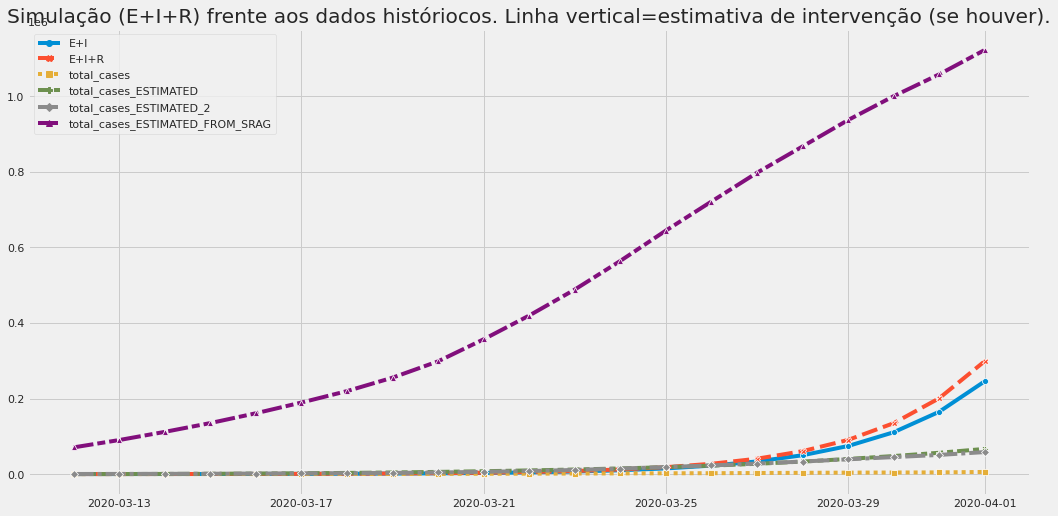

In [59]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [60]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [61]:
def optimize_using(n_models, max_t=100, algo=hyperopt.tpe.suggest, max_evals=3000, trials=None, max_duration_per_model=20):
    assert n_models >= 1
        
    regimens = [{'alpha': hyperopt.hp.uniform('alpha_0', 0.99, 1.0), 'beta': hyperopt.hp.normal('beta_0', 0.7, 0.2),
                 'gamma': hyperopt.hp.normal('gamma_0', 0.5, 0.3),
                 'duration': hyperopt.hp.uniform('duration_0', 1.0, 20.0)}]

    for i in range(1, n_models):
        # assuming gamma_0 == gamma_1 == gamma_2 == ...
        regimens.append(
            {'alpha': hyperopt.hp.uniform(f'alpha_{i}', 0.99, 1.0), 'beta': hyperopt.hp.normal(f'beta_{i}', 0.7, 0.2),
             'duration': hyperopt.hp.uniform(f'duration_{i}', 1.0, max_duration_per_model)})

    space = \
        {'dynamic':\
            (regimens, 0, max_t)}
           
    
    
    best = hyperopt.fmin(objective_for_simulation, space, algo=algo, max_evals=max_evals, trials=trials)
    
    for par_name in ['alpha', 'beta', 'gamma']:
        for i in range(0, n_models):
            key = f'{par_name}_{i}'
            if key in best:
                best[key] = enforce_bounds(best[key])
                
    alpha = dynamic_parameter([(best[f'alpha_{i}'], best[f'duration_{i}']) for i in range(0, n_models)],
                              min_length=epidemic_duration_in_days)
    beta = dynamic_parameter([(best[f'beta_{i}'], best[f'duration_{i}']) for i in range(0, n_models)],
                              min_length=epidemic_duration_in_days)
    gamma = dynamic_parameter([(best[f'gamma_0'], best[f'duration_{i}']) for i in range(0, n_models)],
                              min_length=epidemic_duration_in_days)
                
    return best, alpha, beta, gamma

In [62]:
%%time
trials = hyperopt.Trials()
best, alpha, beta, gamma = optimize_using(n_models=3, max_t = 200, algo=hyperopt.tpe.suggest, max_evals=5000, trials=trials, max_duration_per_model=40)

# Annealing seems to go much faster and provide comparable or better results than TPE. So we are using it here. Other optons would be:
#
#   hyperopt.tpe.suggest
#   hyperopt.anneal.suggest
#   hyperopt.atpe.suggest
#   hyperopt.rand.suggest

print("Best parameters found:", best)

100%|██████████| 5000/5000 [07:21<00:00, 11.32trial/s, best loss: 140328.70495704995]
Best parameters found: {'alpha_0': 0.9975420677984933, 'alpha_1': 0.9957446322976878, 'alpha_2': 0.9903850331639196, 'beta_0': 0.5721084648671655, 'beta_1': 1.0, 'beta_2': 0.5532288204348547, 'duration_0': 9.204431009080986, 'duration_1': 31.26180154377747, 'duration_2': 22.21542297644843, 'gamma_0': 0.5234268780518369}
CPU times: user 7min 19s, sys: 2.18 s, total: 7min 21s
Wall time: 7min 21s


Comparando as versões com e sem mitigação, temos o seguinte.

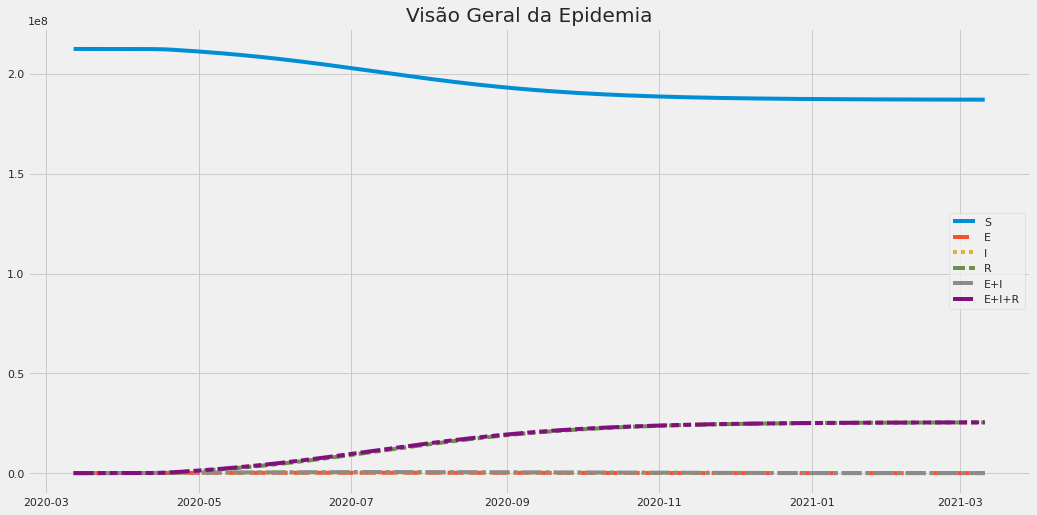

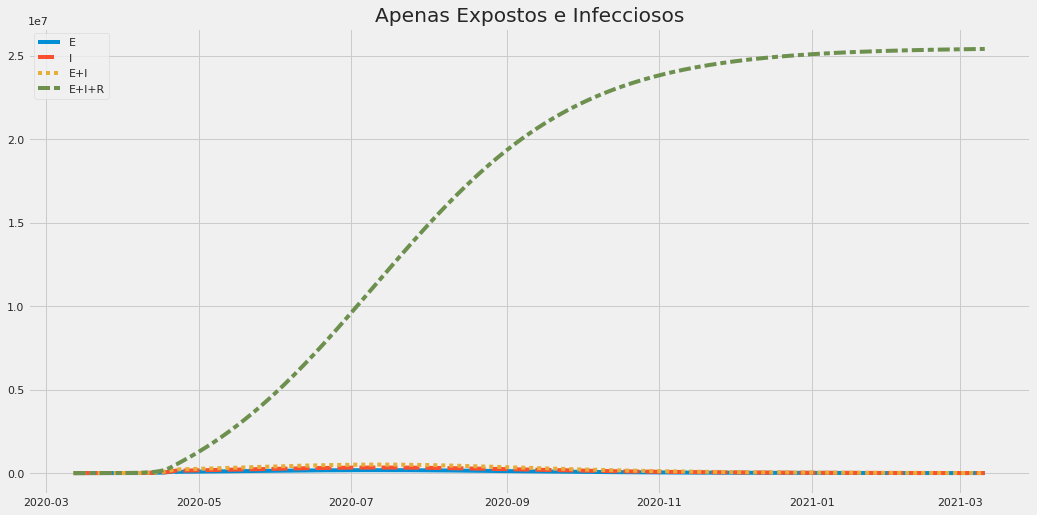

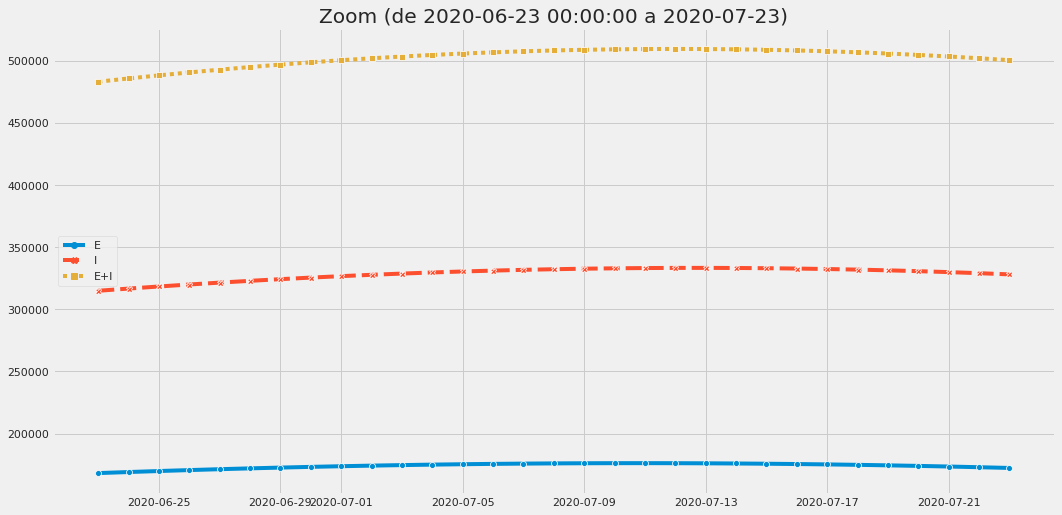

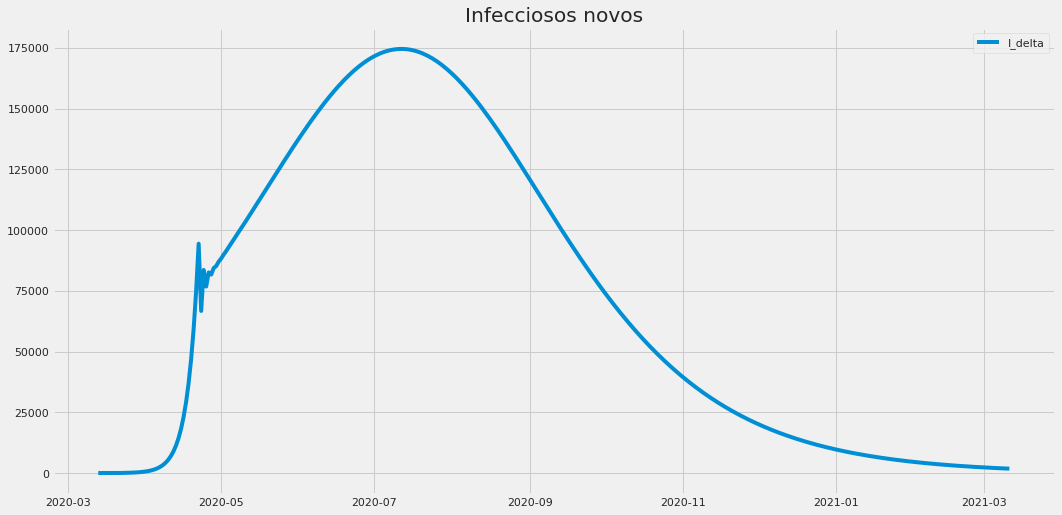

<Figure size 1152x576 with 0 Axes>

In [63]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected - initially_recovered, 
                                          E=initially_infected,
                                          I=0,
                                          R=initially_recovered, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30)#, file_name='dynamic')

In [64]:
best['beta_2'] / best['gamma_0']

1.0569362094929837

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

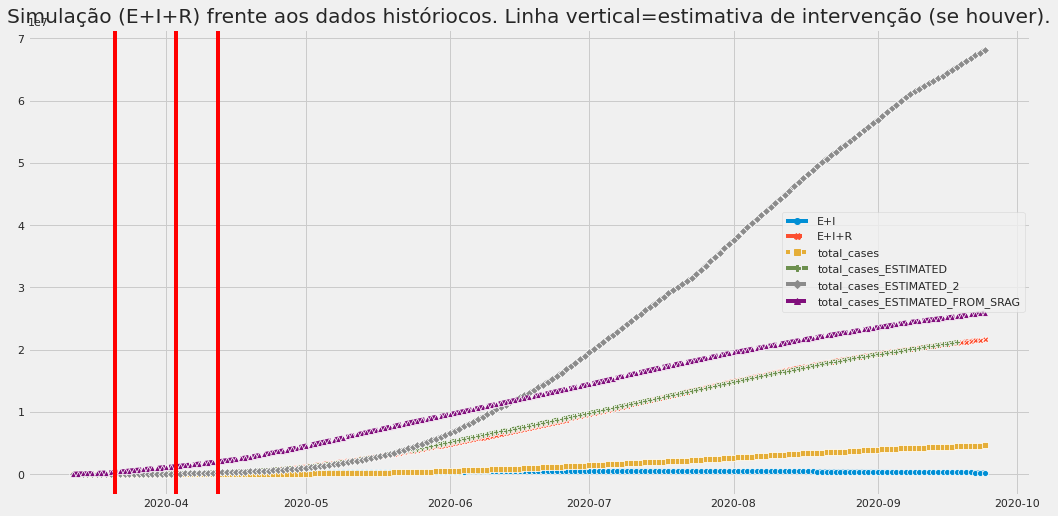

In [65]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best)#, 
                   #file_name='seir_dynamic_fit_zoom')

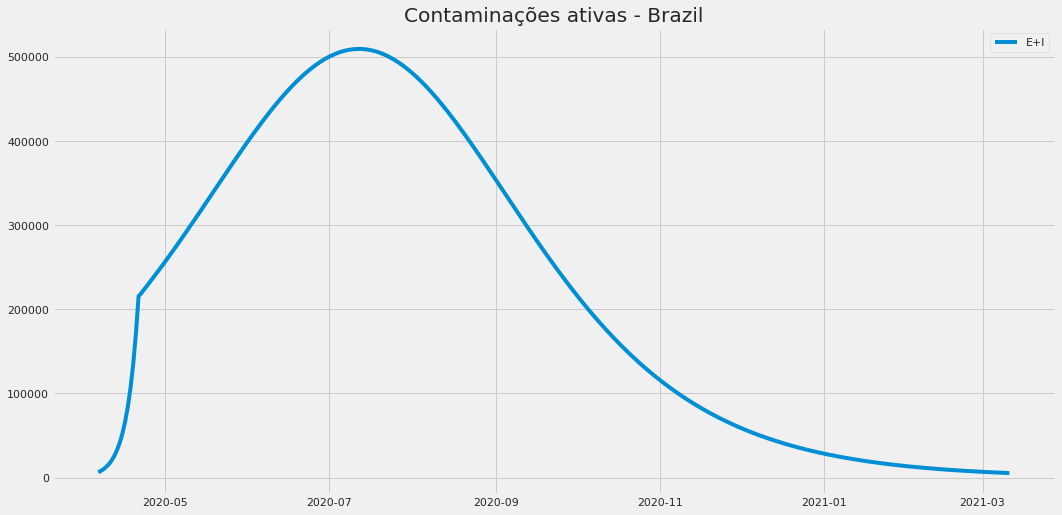

<Figure size 1152x576 with 0 Axes>

In [66]:
plot_simple_simulation_output(df_simulation_mitigation_data, 
                              title=f"Contaminações ativas - {target_location}", 
                              min_peak_proportion_to_show=0.01,
                              file_path_base=results_folder, file_name=f'active_curve')

Data estimada do pico de contaminações ativas:

In [67]:
df_simulation_mitigation_data["E+I"].idxmax().date()

datetime.date(2020, 7, 12)

Finalmente, comparemos o modelo que emprega parâmetros constantes e dados iniciais com o modelo completo.

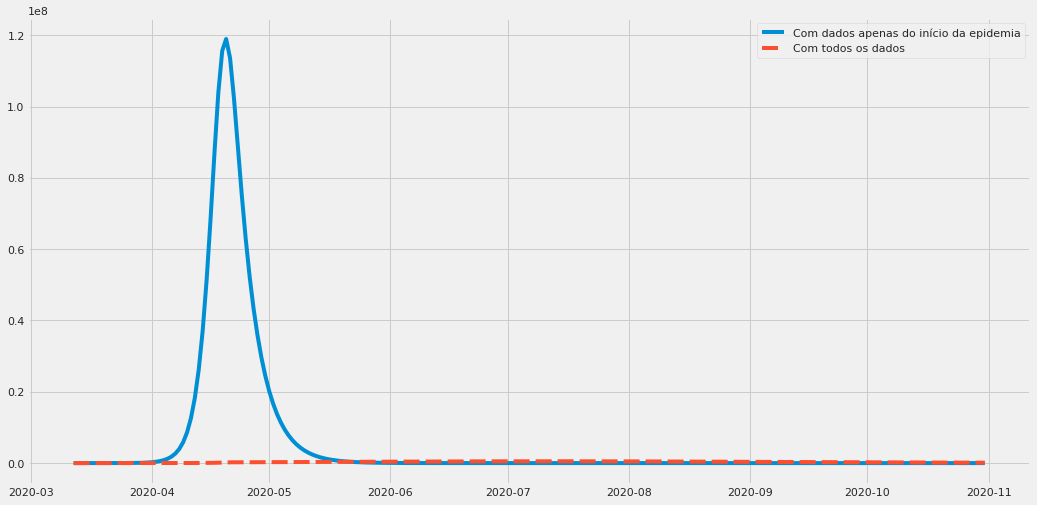

In [68]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Com dados apenas do início da epidemia'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com todos os dados')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [69]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [70]:
len(df_data_target)

198

In [71]:
min_data_points = 30

In [72]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    prev_loss = None
    
    for t in range(min_data_points, len(df_data_target), sensitivity_analysis_step):
        print(f'###### t={t} ######')

        # try the optimization a number of times so that the losses from one moment to the other are not so different.
        retry = True
        retry_count = 0
        prev_min_loss = None
        while retry:
            trials = hyperopt.Trials()
            #tmp_best, tmp_alpha, tmp_beta, tmp_gamma = optimize_using(n_models=3, max_t=t, algo=hyperopt.anneal.suggest, max_evals=3000, trials=trials)
            tmp_best, tmp_alpha, tmp_beta, tmp_gamma = optimize_using(n_models=3, max_t=t, algo=hyperopt.tpe.suggest, max_evals=1500, trials=trials)

            min_loss = min(trials.losses())
            
            # compare with the loss from the previous loop on the current time point. This ensures that even if we cannot find the desired error change,
            # we still keep the minimum found so far.
            if (prev_min_loss is None) or (min_loss < prev_min_loss):
                prev_min_loss = min_loss
                best = tmp_best
                alpha = tmp_alpha
                beta = tmp_beta
                gamma = tmp_gamma
            
                
            # compare with the loss from the previous time point
            if prev_loss is None:
                prev_loss = min_loss
                retry = False
                prev_min_loss = None
            else:
                delta = abs(min_loss - prev_loss)/prev_loss
                print("delta=", delta)
                if (delta > 0.5) and (retry_count < 20):
                    retry = True
                    retry_count += 1
                else:
                    retry = False
                    prev_loss = min_loss
                    retry_count = 0
                    prev_min_loss = None
        
        print("Best parameters found:", best)

        try:
            r0_0 = best['beta_0'] / best['gamma_0']
            r0_1 = best['beta_1'] / best['gamma_0'] # / best['gamma_1']
            r0_2 = best['beta_2'] / best['gamma_0'] # / best['gamma_2']
            #r0_3 = best['beta_3'] / best['gamma_0'] # / best['gamma_3']

            r0s.append((r0_0, r0_1, r0_2))#, r0_3))
            print(f'R0_0={r0_0}, R0_1={r0_1}, R0_2={r0_2}')#, R0_3={r0_3}')
            
        except Exception:
            r0s.append((0, 0, 0, 0))
            print(f'Exception while calculating R0.')

        df_simulation_partial_data = simulate(S=population_size - initially_infected - initially_recovered, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=initially_recovered, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)
        
        print("Peak date=", df_simulation_partial_data['E+I'].idxmax().date())
        
        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

###### t=30 ######
100%|██████████| 1500/1500 [01:03<00:00, 23.79trial/s, best loss: 2523.747016239507]
Best parameters found: {'alpha_0': 0.9926545484506983, 'alpha_1': 0.9901489521324645, 'alpha_2': 0.9941363089657503, 'beta_0': 1.0, 'beta_1': 0.48022630268470373, 'beta_2': 0.3644095646980329, 'duration_0': 14.838630366982445, 'duration_1': 1.000716565728966, 'duration_2': 7.2626586373608, 'gamma_0': 0.20552610069935257}
R0_0=4.865562070205471, R0_1=2.336570883457706, R0_2=1.7730573560148355
Peak date= 2020-06-10
###### t=31 ######
100%|██████████| 1500/1500 [01:02<00:00, 23.89trial/s, best loss: 4251.409871560661]
delta= 0.6845626143207676
100%|██████████| 1500/1500 [01:05<00:00, 22.97trial/s, best loss: 2187.809775892117] 
delta= 0.133110505207432
Best parameters found: {'alpha_0': 0.9995554076925142, 'alpha_1': 0.99078103909956, 'alpha_2': 0.9904130165540801, 'beta_0': 1.0, 'beta_1': 0.5771700555067173, 'beta_2': 0.32557811137099857, 'duration_0': 12.868043887507493, 'duration_1':

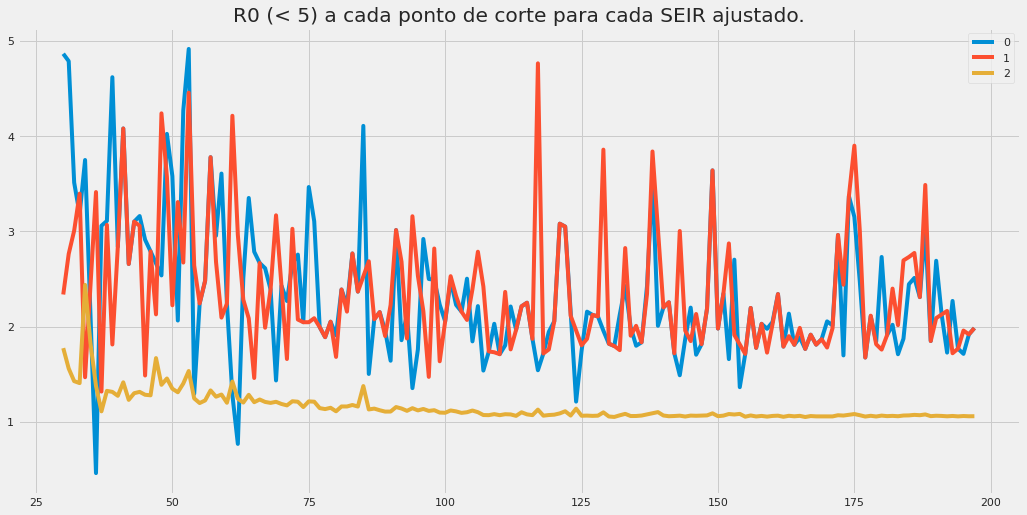

In [73]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame([[np.nan*len(r0s[0])]]*min_data_points + r0s)
    df_r0 = df_r0[df_r0 < 5]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)
    ax.set_title("R0 (< 5) a cada ponto de corte para cada SEIR ajustado.")

In [74]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [75]:
def peak_dates_statistics(df):
    peak_dates = []
    for i in range(0, df.shape[1]):
        peak_dates.append(pd.Timestamp(df.iloc[:, i].idxmax().date()))

    peak_dates.sort()
    n = len(peak_dates)
    median_peak_date = peak_dates[int(n/2)]
    #print(f'Median peak date={median_peak_date}')
    peak_dates_diffs = [(d - median_peak_date).days for d in peak_dates]

    return np.mean(peak_dates_diffs), np.std(peak_dates_diffs)

Média e desvio padrão dos picos de datas (em dias): (2.3666666666666667, 8.039416783711504)


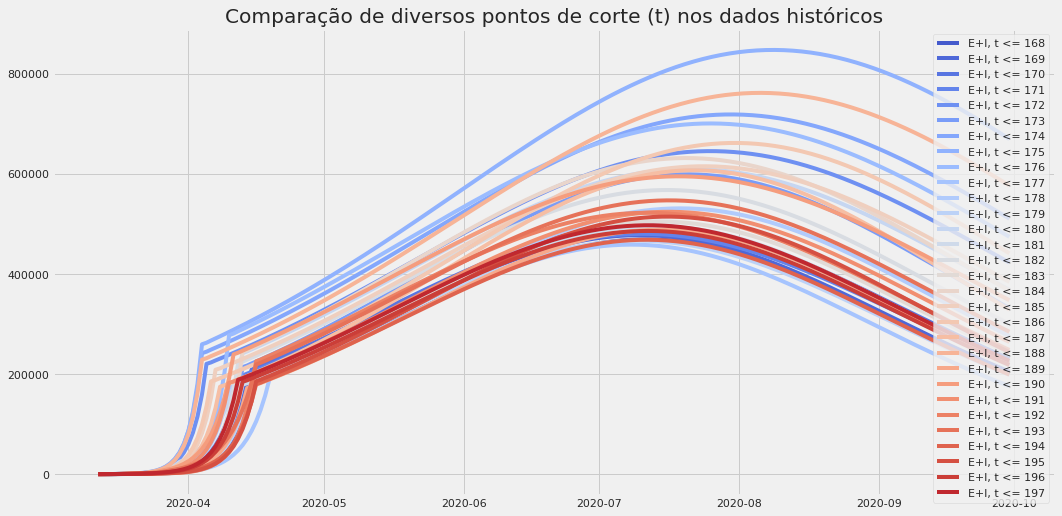

In [76]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, -30:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')
    
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_0' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')
    
    print("Média e desvio padrão dos picos de datas (em dias):", peak_dates_statistics(df_filtered))

Média e desvio padrão dos picos de datas (em dias): (0.6666666666666666, 8.666666666666666)


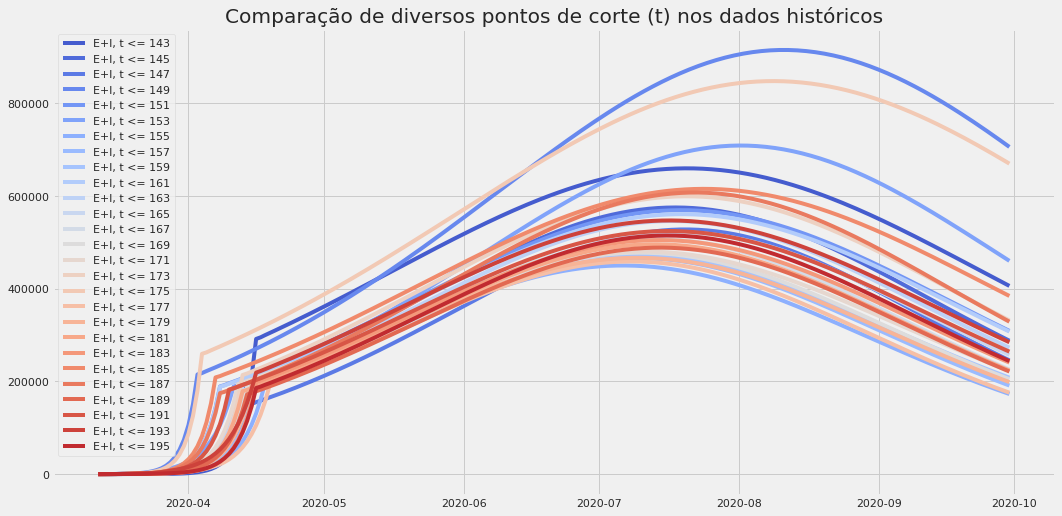

In [77]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, -55:-1:2]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')
    
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_1' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')
    
    print("Média e desvio padrão dos picos de datas (em dias):", peak_dates_statistics(df_filtered))

Média e desvio padrão dos picos de datas (em dias): (1.8035714285714286, 13.314089801593573)


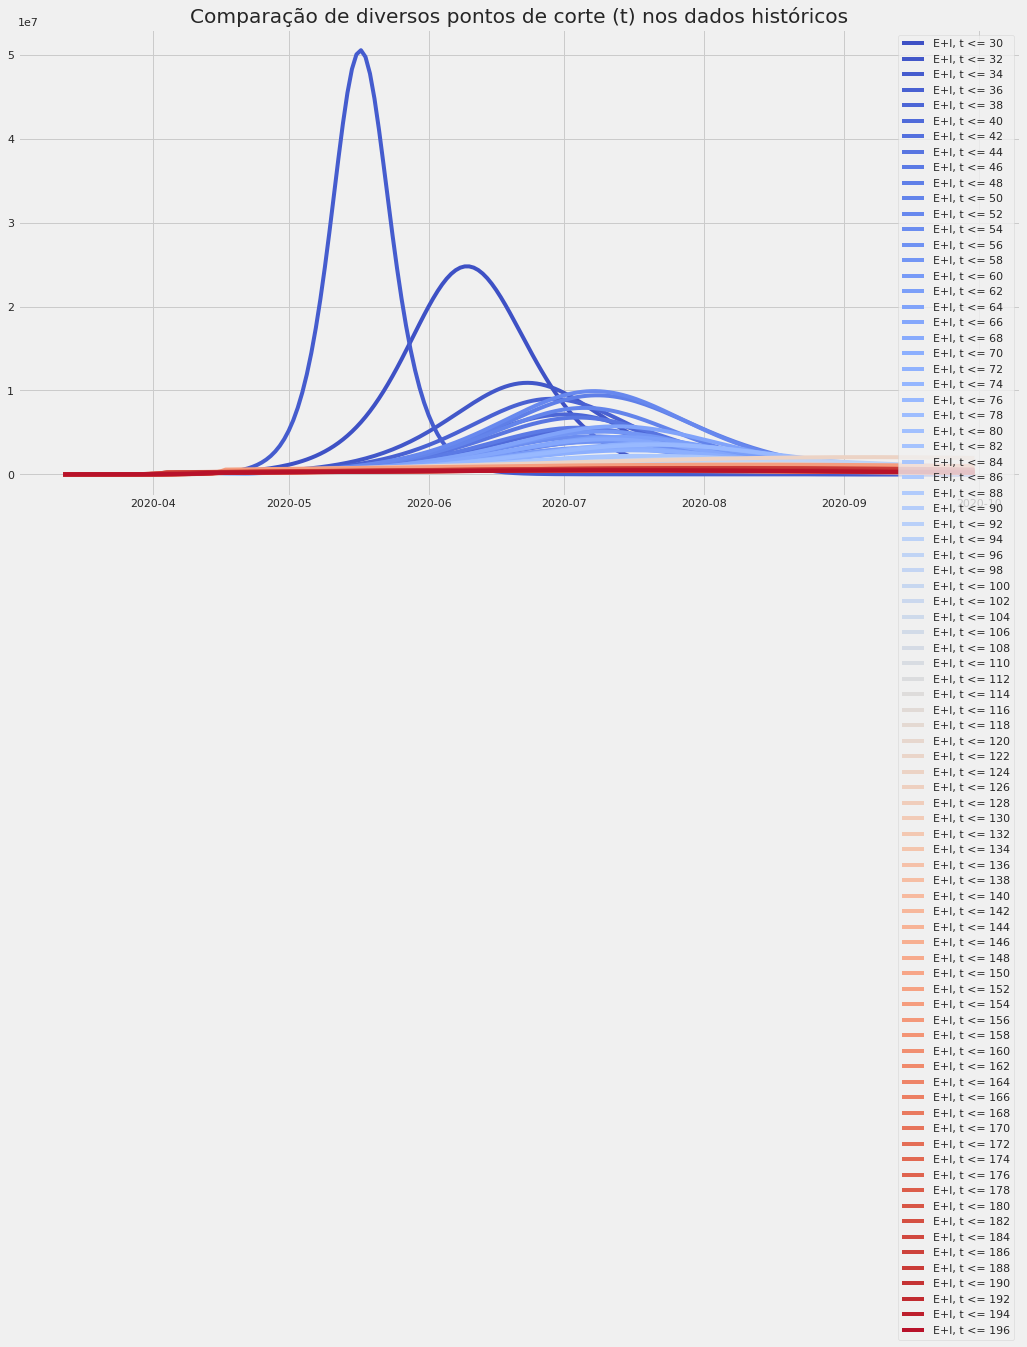

In [78]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 0:-1:2]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')
    
    print("Média e desvio padrão dos picos de datas (em dias):", peak_dates_statistics(df))

In [79]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade. Mas como exatamente a estabilidade evolui ao longo do tempo?

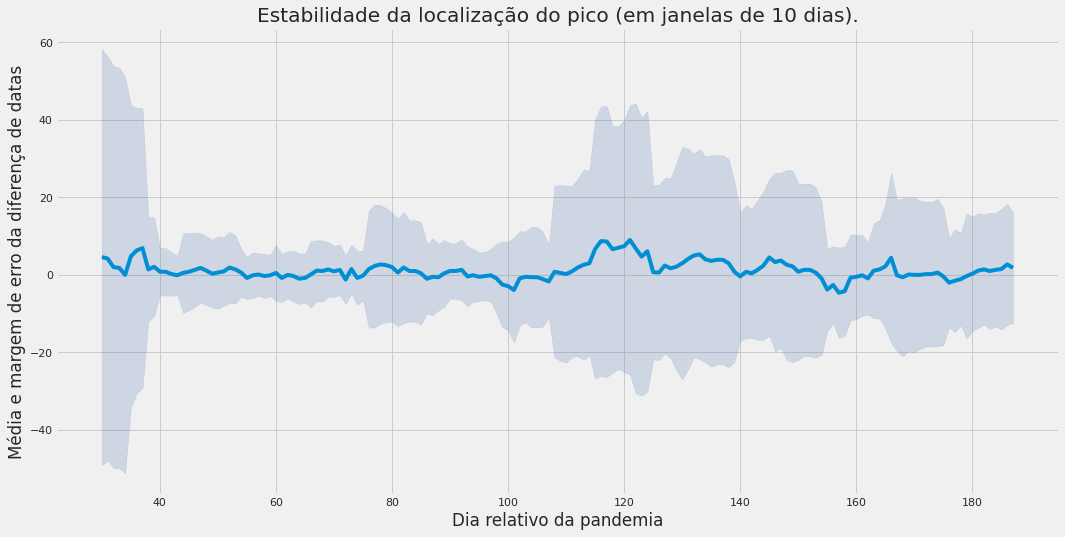

In [80]:
if run_sensitivity_analysis:
    means_stds = []
    for x in range(0, df.shape[1]-10):
        df_filtered = df.iloc[:, x:x+10]
        means_stds.append(peak_dates_statistics(df_filtered))
    
    df_means_stds = pd.DataFrame([[np.nan*2]]*min_data_points + means_stds)
    
    ax = df_means_stds.iloc[:, 0].plot(title="Estabilidade da localização do pico (em janelas de 10 dias).")
    ax.set_xlabel("Dia relativo da pandemia")
    ax.set_ylabel("Média e margem de erro da diferença de datas")
    plt.fill_between(df_means_stds.index, 
                     df_means_stds.iloc[:, 0] - 2 * df_means_stds.iloc[:, 1], 
                     df_means_stds.iloc[:, 0] + 2 * df_means_stds.iloc[:, 1], 
                     color='b', alpha=0.2)

Temos então que, de fato, quando mais avançamos, menores as diferenças introduzidas. 